In [1]:
# 调库,这里的gdatasdk是服务器环境的库
import pandas as pd
import numpy as np
from qdatasdk import *
import matplotlib.pyplot as plt
from MyModel import Model1, Model2, DataCleaner
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tqdm

# 加载parameters
security=get_all_securities().index.tolist()
start_date=["2021-01-01","2022-01-01","2023-01-01"]
end_date=["2021-12-31","2022-12-31","2023-12-31"]
dates=get_trade_days(start_date=start_date[0], end_date=end_date[2], count=None)
#这里返回的是一个datetime的list
# 现在建立一个dataframe，index是dates，columns名是loss_ratio，初始值均为0
result=pd.DataFrame(index=dates,columns=["loss_ratio","loss_ratio_list"])
result["loss_ratio"] = result["loss_ratio"].apply(lambda x: 1000)
result["loss_ratio_list"] = result["loss_ratio_list"].apply(lambda x: [])

# 定义结果
Model1_R2=[]
Model1_beta=[]
Model1_alpha=[]
Model2_R2=[]
Model2_beta_1=[]
Model2_beta_7=[]
Model2_alpha=[]
Lasso1_R2=[]
Ridge1_R2=[]
Basis1_R2=[]
KNN1_R2=[]
SVM1_R2=[]
RandomForest1_R2=[]
Lasso2_R2=[]
Ridge2_R2=[]
Basis2_R2=[]
KNN2_R2=[]
SVM2_R2=[]
RandomForest2_R2=[]


security=security[0:1000]
len(security)

1000

In [2]:


# 加载数据
cnt=0
for i in tqdm.tqdm(security):
    df1 = get_bars(security=str(i), start_date=start_date[0], end_date=end_date[0], unit="1m",type="stock")
    if df1 is None:
        print(f"数据获取失败: {str(i)}")
        continue
    df2 = get_bars(security=str(i), start_date=start_date[1], end_date=end_date[1], unit="1m",type="stock")
    if df2 is None:
        print(f"数据获取失败: {str(i)}")
        continue
    df3 = get_bars(security=str(i), start_date=start_date[2], end_date=end_date[2], unit="1m",type="stock")
    if df3 is None:
        print(f"数据获取失败: {str(i)}")
        continue
    df = pd.concat([df1, df2, df3], axis=0)
    if df is None:
        print(f"数据获取失败: {str(i)}")
        continue
    df = df.reset_index().rename(columns={'index': 'date'})

    # 清洗数据
    dataCleaner=DataCleaner(df)
    dataCleaner.clean()
    r1=dataCleaner.getR1()
    r7=dataCleaner.getR7()
    r8=dataCleaner.getR8()
    theDates=dataCleaner.getDates()
    
    # 拟合模型
    # Model1
    model1=Model1(r8,r1)
    model1.fit()
    Model1_R2.append(model1.getR2())
    Model1_beta.append(model1.getBeta())
    Model1_alpha.append(model1.getAlpha())
    # print("Model1 Alpha:", model1.getAlpha())
    # print("Model1 Beta:", model1.getBeta())
    # print("Model1 R2:", model1.getR2())
    # model1.plot()

    # Model2
    model2 = Model2(r8, r1, r7)
    model2.fit()
    Model2_R2.append(model2.getR2())
    Model2_beta_1.append(model2.getBeta_r1())
    Model2_beta_7.append(model2.getBeta_r7())
    Model2_alpha.append(model2.getAlpha())
    # print("Model2 Alpha:", model2.getAlpha())
    # print("Model2 Beta_r1:", model2.getBeta_r1())
    # print("Model2 Beta_r7:", model2.getBeta_r7())
    # print("Model2 R2:", model2.getR2())
    # model2.plot()


    # 将数据分为训练集和测试集
    r1_train, r1_test, r8_train, r8_test = train_test_split(r1, r8, test_size=0.3, random_state=42)
    r7_train, r7_test = train_test_split(r7, test_size=0.3, random_state=42)

    # 转换为数组并重塑
    r1_train = np.array(r1_train).reshape(-1, 1)
    r1_test = np.array(r1_test).reshape(-1, 1)
    r7_train = np.array(r7_train).reshape(-1, 1)
    r7_test = np.array(r7_test).reshape(-1, 1)
    r8_train = np.array(r8_train).ravel()
    r8_test = np.array(r8_test).ravel()

    # Lasso1
    lasso = Lasso()
    lasso.fit(r1_train, r8_train)
    Lasso1_R2.append(lasso.score(r1_test, r8_test))

    # Lasso2
    lasso = Lasso()
    lasso.fit(np.hstack((r1_train, r7_train)), r8_train)
    Lasso2_R2.append(lasso.score(np.hstack((r1_test, r7_test)), r8_test))

    # Ridge1
    ridge = Ridge()
    ridge.fit(r1_train, r8_train)
    Ridge1_R2.append(ridge.score(r1_test, r8_test))

    # Ridge2
    ridge = Ridge()
    ridge.fit(np.hstack((r1_train, r7_train)), r8_train)
    Ridge2_R2.append(ridge.score(np.hstack((r1_test, r7_test)), r8_test))

    # Basis1
    poly = PolynomialFeatures(degree=3)
    r1_poly_train = poly.fit_transform(r1_train)
    r1_poly_test = poly.transform(r1_test)
    basis = Ridge()
    basis.fit(r1_poly_train, r8_train)
    Basis1_R2.append(basis.score(r1_poly_test, r8_test))

    # Basis2
    r7_poly_train = poly.fit_transform(r7_train)
    r7_poly_test = poly.transform(r7_test)
    basis = Ridge()
    basis.fit(np.hstack((r1_poly_train, r7_poly_train)), r8_train)
    Basis2_R2.append(basis.score(np.hstack((r1_poly_test, r7_poly_test)), r8_test))

    # KNN1
    knn = KNeighborsRegressor()
    knn.fit(r1_train, r8_train)
    KNN1_R2.append(knn.score(r1_test, r8_test))

    # KNN2
    knn = KNeighborsRegressor()
    knn.fit(np.hstack((r1_train, r7_train)), r8_train)
    KNN2_R2.append(knn.score(np.hstack((r1_test, r7_test)), r8_test))

    # SVM1
    svm = SVR()
    svm.fit(r1_train, r8_train)
    SVM1_R2.append(svm.score(r1_test, r8_test))

    # SVM2
    svm = SVR()
    svm.fit(np.hstack((r1_train, r7_train)), r8_train)
    SVM2_R2.append(svm.score(np.hstack((r1_test, r7_test)), r8_test))

    # RandomForest1
    rf = RandomForestRegressor()
    rf.fit(r1_train, r8_train)
    RandomForest1_R2.append(rf.score(r1_test, r8_test))

    # RandomForest2
    rf = RandomForestRegressor()
    rf.fit(np.hstack((r1_train, r7_train)), r8_train)
    RandomForest2_R2.append(rf.score(np.hstack((r1_test, r7_test)), r8_test))
    
    cnt += 1
    # print("\r Progress:{}/{}       ".format(cnt, len(security)), end="")

    

  1%|▏         | 14/1000 [01:56<2:12:43,  8.08s/it]

数据获取失败: 000018.XSHE


  2%|▏         | 20/1000 [02:36<2:06:30,  7.75s/it]

数据获取失败: 000024.XSHE


  3%|▎         | 29/1000 [03:41<2:08:40,  7.95s/it]

数据获取失败: 000033.XSHE


  8%|▊         | 78/1000 [10:02<2:03:07,  8.01s/it]

数据获取失败: 000406.XSHE


  9%|▉         | 88/1000 [11:14<2:00:46,  7.95s/it]

数据获取失败: 000418.XSHE


 10%|█         | 103/1000 [13:02<1:39:27,  6.65s/it]

数据获取失败: 000502.XSHE


 11%|█         | 108/1000 [13:42<1:55:35,  7.78s/it]

数据获取失败: 000508.XSHE


 11%|█         | 111/1000 [13:58<1:44:05,  7.02s/it]

数据获取失败: 000511.XSHE


 11%|█▏        | 114/1000 [14:14<1:38:44,  6.69s/it]

数据获取失败: 000515.XSHE


 12%|█▏        | 121/1000 [15:02<1:52:28,  7.68s/it]

数据获取失败: 000522.XSHE


 13%|█▎        | 126/1000 [15:34<1:49:41,  7.53s/it]

数据获取失败: 000527.XSHE


 14%|█▍        | 140/1000 [17:16<1:49:33,  7.64s/it]

数据获取失败: 000542.XSHE


 15%|█▍        | 147/1000 [18:04<1:50:26,  7.77s/it]

数据获取失败: 000549.XSHE


 16%|█▌        | 159/1000 [19:32<1:51:07,  7.93s/it]

数据获取失败: 000562.XSHE


 17%|█▋        | 166/1000 [20:20<1:48:38,  7.82s/it]

数据获取失败: 000569.XSHE


 17%|█▋        | 172/1000 [21:00<1:46:10,  7.69s/it]

数据获取失败: 000578.XSHE


 18%|█▊        | 177/1000 [21:28<1:23:22,  6.08s/it]

数据获取失败: 000585.XSHE


 18%|█▊        | 184/1000 [22:21<1:45:11,  7.73s/it]

数据获取失败: 000594.XSHE


 19%|█▉        | 192/1000 [23:17<1:45:14,  7.81s/it]

数据获取失败: 000602.XSHE


 20%|██        | 201/1000 [24:15<1:25:49,  6.45s/it]

数据获取失败: 000611.XSHE


 20%|██        | 203/1000 [24:26<1:17:38,  5.84s/it]

数据获取失败: 000613.XSHE


 21%|██        | 206/1000 [24:49<1:31:56,  6.95s/it]

数据获取失败: 000618.XSHE


 23%|██▎       | 234/1000 [28:18<1:13:03,  5.72s/it]

数据获取失败: 000662.XSHE


 24%|██▍       | 240/1000 [29:03<1:34:02,  7.42s/it]

数据获取失败: 000670.XSHE


 24%|██▍       | 244/1000 [29:21<1:12:33,  5.76s/it]

数据获取失败: 000673.XSHE


 26%|██▌       | 255/1000 [30:45<1:22:09,  6.62s/it]

数据获取失败: 000687.XSHE


 26%|██▌       | 259/1000 [31:17<1:34:36,  7.66s/it]

数据获取失败: 000693.XSHE


 30%|██▉       | 298/1000 [36:20<1:33:04,  7.96s/it]

数据获取失败: 000748.XSHE


 31%|███       | 309/1000 [37:33<1:05:16,  5.67s/it]

数据获取失败: 000760.XSHE


 31%|███       | 311/1000 [37:49<1:18:52,  6.87s/it]

数据获取失败: 000763.XSHE


 32%|███▏      | 320/1000 [38:48<1:09:41,  6.15s/it]

数据获取失败: 000780.XSHE


 35%|███▍      | 348/1000 [42:29<1:26:34,  7.97s/it]

数据获取失败: 000817.XSHE


 36%|███▋      | 363/1000 [44:16<1:09:35,  6.55s/it]

数据获取失败: 000835.XSHE


 38%|███▊      | 378/1000 [46:17<1:23:06,  8.02s/it]

数据获取失败: 000866.XSHE


 42%|████▏     | 415/1000 [51:05<1:18:26,  8.05s/it]

数据获取失败: 000916.XSHE


 44%|████▎     | 436/1000 [53:45<1:15:55,  8.08s/it]

数据获取失败: 000939.XSHE


 44%|████▍     | 444/1000 [54:41<1:13:28,  7.93s/it]

数据获取失败: 000956.XSHE


 46%|████▋     | 465/1000 [57:21<1:11:18,  8.00s/it]

数据获取失败: 000979.XSHE


 50%|████▉     | 499/1000 [1:01:43<1:04:54,  7.77s/it]

数据获取失败: 002018.XSHE


 56%|█████▌    | 555/1000 [1:09:05<59:37,  8.04s/it]  

数据获取失败: 002070.XSHE


 56%|█████▌    | 557/1000 [1:09:06<42:07,  5.71s/it]

数据获取失败: 002071.XSHE


 63%|██████▎   | 630/1000 [1:18:49<49:36,  8.04s/it]

数据获取失败: 002143.XSHE


 64%|██████▍   | 641/1000 [1:20:04<39:41,  6.63s/it]

数据获取失败: 002147.XSHE


 71%|███████   | 710/1000 [1:29:17<38:38,  8.00s/it]

数据获取失败: 002220.XSHE


 75%|███████▌  | 750/1000 [1:34:29<33:27,  8.03s/it]

数据获取失败: 002260.XSHE


 84%|████████▍ | 843/1000 [1:46:43<17:26,  6.66s/it]

数据获取失败: 300023.XSHE


 85%|████████▌ | 850/1000 [1:47:39<19:45,  7.90s/it]

数据获取失败: 300028.XSHE


 90%|█████████ | 902/1000 [1:54:21<09:21,  5.73s/it]

数据获取失败: 002359.XSHE


 91%|█████████ | 906/1000 [1:54:48<09:34,  6.11s/it]

数据获取失败: 300038.XSHE


100%|█████████▉| 999/1000 [2:07:07<00:06,  6.54s/it]

数据获取失败: 300064.XSHE


100%|██████████| 1000/1000 [2:07:15<00:00,  7.64s/it]


Model1_R2:0.007183826323337612


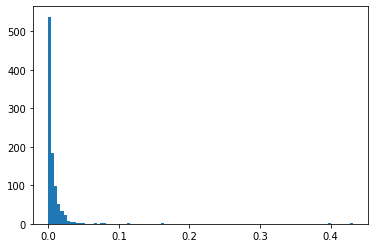

Model2_R2:0.016023829199760906


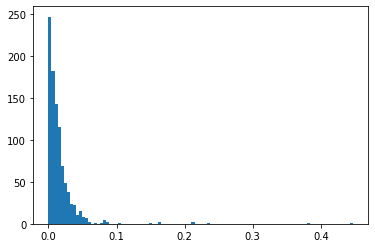

Lasso1_R2:-0.005931237102964577


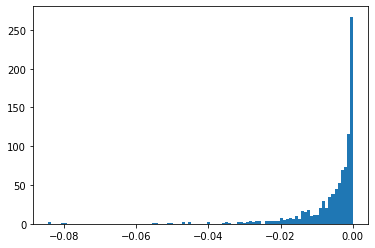

Lasso2_R2:-0.005931237102964577


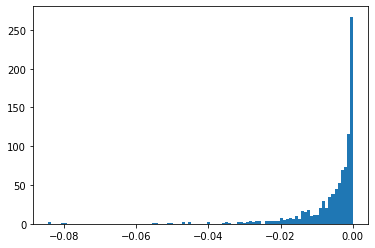

Ridge1_R2:-0.006645788051969982


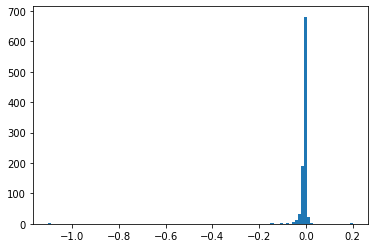

Ridge2_R2:-0.006555694213219476


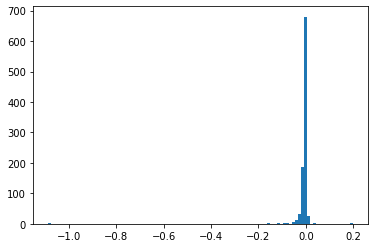

Basis1_R2:-0.00638961529036751


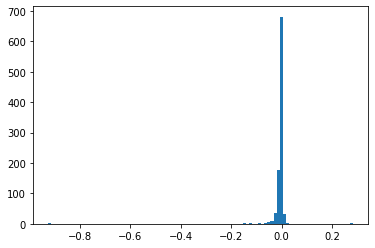

Basis2_R2:-0.006299295816952015


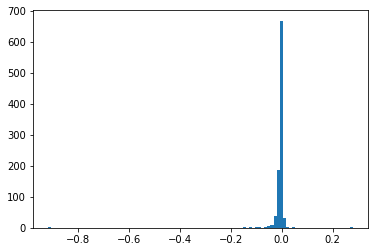

KNN1_R2:-0.204473481409657


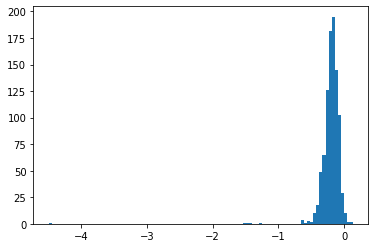

KNN2_R2:-0.18016970604646027


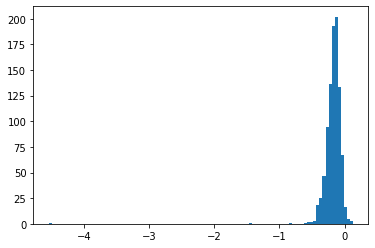

SVM1_R2:-4.28903783914544


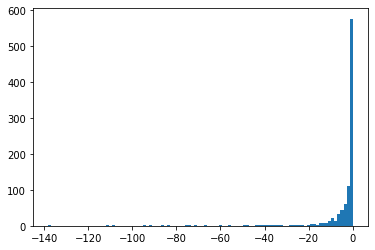

SVM2_R2:-4.3804112702747355


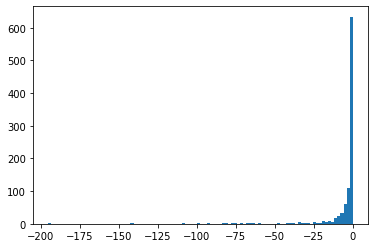

RandomForest1_R2:-0.47297205356470207


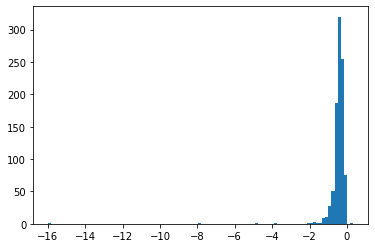

RandomForest2_R2:-0.2624797332287911


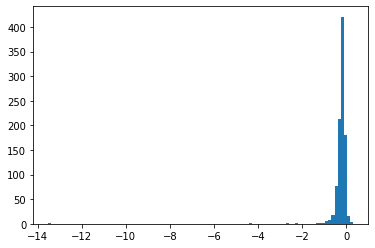

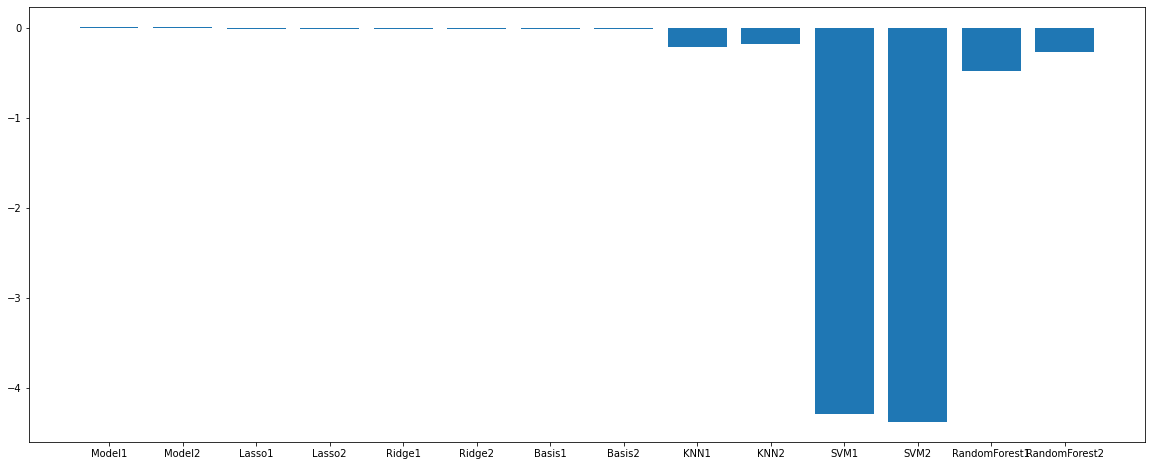

In [4]:
# 统计数据&可视化
n=100

print("Model1_R2:"+str(np.nanmean(Model1_R2)))
plt.hist(Model1_R2,n)
plt.show()

print("Model2_R2:"+str(np.nanmean(Model2_R2)))
plt.hist(Model2_R2,n)
plt.show()

print("Lasso1_R2:"+str(np.nanmean(Lasso1_R2)))
plt.hist(Lasso1_R2,n)
plt.show()

print("Lasso2_R2:"+str(np.nanmean(Lasso2_R2)))
plt.hist(Lasso2_R2,n)
plt.show()

print("Ridge1_R2:"+str(np.nanmean(Ridge1_R2)))
plt.hist(Ridge1_R2,n)
plt.show()

print("Ridge2_R2:"+str(np.nanmean(Ridge2_R2)))
plt.hist(Ridge2_R2,n)
plt.show()

print("Basis1_R2:"+str(np.nanmean(Basis1_R2)))
plt.hist(Basis1_R2,n)
plt.show()

print("Basis2_R2:"+str(np.nanmean(Basis2_R2)))
plt.hist(Basis2_R2,n)
plt.show()

print("KNN1_R2:"+str(np.nanmean(KNN1_R2)))
plt.hist(KNN1_R2,n)
plt.show()

print("KNN2_R2:"+str(np.nanmean(KNN2_R2)))
plt.hist(KNN2_R2,n)
plt.show()

print("SVM1_R2:"+str(np.nanmean(SVM1_R2)))
plt.hist(SVM1_R2,n)
plt.show()

print("SVM2_R2:"+str(np.nanmean(SVM2_R2)))
plt.hist(SVM2_R2,n)
plt.show()

print("RandomForest1_R2:"+str(np.nanmean(RandomForest1_R2)))
plt.hist(RandomForest1_R2,n)
plt.show()

print("RandomForest2_R2:"+str(np.nanmean(RandomForest2_R2)))
plt.hist(RandomForest2_R2,n)
plt.show()

plt.bar(["Model1","Model2","Lasso1","Lasso2","Ridge1","Ridge2","Basis1","Basis2","KNN1","KNN2","SVM1","SVM2","RandomForest1","RandomForest2"],
        [np.nanmean(Model1_R2),np.nanmean(Model2_R2),np.nanmean(Lasso1_R2),np.nanmean(Lasso2_R2),np.nanmean(Ridge1_R2),np.nanmean(Ridge2_R2),np.nanmean(Basis1_R2),np.nanmean(Basis2_R2),np.nanmean(KNN1_R2),np.nanmean(KNN2_R2),np.nanmean(SVM1_R2),np.nanmean(SVM2_R2),np.nanmean(RandomForest1_R2),np.nanmean(RandomForest2_R2)])
plt.gcf().set_size_inches(20, 8)
plt.savefig("compareModel.png")
plt.show()